In [1]:
import networkx as nx
from community import community_louvain as cm
import numpy as np
import scipy as sp
from numpy import linalg as la

In [2]:
# read yeast protein interaction file
g = nx.read_weighted_edgelist("4932.protein.links.v11.5.txt",comments="#",nodetype=str)

In [55]:
# thresholding
threshold_score = 750
for edge in g.edges: 
    weight = list(g.get_edge_data(edge[0],edge[1]).values())
    if(weight[0] <= threshold_score):
        g.remove_edge(edge[0],edge[1])

In [56]:
#remove essential nodes
file = open("essential_nodes.txt")
for line in file.readlines():
    node = line.strip()
    if node in g:
        g.remove_node(node)
file.close()

In [57]:
#select largest component
components = sorted(nx.connected_components(g), key=len, reverse=True)
g = g.subgraph(components[0])

In [62]:
# add new interactions
g_mutant = g.copy()
file = open("new_interactions.txt")
for line in file.readlines():
    node = line.strip()
    if node in g:
        g_mutant.add_edge('4932.YJR104C', node)
file.close()

In [8]:
#Test robustness of Louvain algorithm across a range of resolutions
trials=20
SD=[]
for R in range(10,21):
    Ncomm=[]
    r=R/10
    for i in range(0,trials):
        partition = cm.best_partition(g,resolution=r)
        Ncomm.append(max(list(partition.values()))+1)
    SD.append(np.std(Ncomm))

In [2]:
def robust_community(target,g):
    global freq_dict
    freq_dict={}
    max=100
    for node in list(g.nodes()):
        freq_dict[node]=0
    for i in range(0,max):
        # louvain partition
        partition = cm.best_partition(g)

        target_module=partition[target]

        for node in list(partition.keys()):
            if partition[node]==target_module:
                freq_dict[node]=freq_dict[node]+1
    freq_dict_filt = dict((k, v) for k, v in freq_dict.items() if v > 0)
    #Calculating size of module for each threshold
    lengths=[]
    for i in range(0,max):
        freq_dict_filt = dict((k, v) for k, v in freq_dict.items() if v > i)
        lengths.append(len(freq_dict_filt))
    plt.plot(lengths)
    plt.title('Frequency plot for nodes in {} community (100 trials)'.format(target))
    plt.xlabel('Number of times appearing in {} community'.format(target))
    plt.ylabel('Number of nodes')
    plt.savefig("robust/{}.png".format(target))
    summary = ["Node,Frequency"]
    for node in g:
        summary.append("{},{}".format(node, freq_dict[node]))
    #write summary to file
    with open("robust2/{}.csv".format(target), "w") as file:
        file.write("\n".join(summary))

In [46]:
def participation_coefficient(graph, partition):
    """return a dictionary with {node:participation_coefficent}"""
    #input: partition is a dictionary, {node:module}
    pc_dict = {}
    N = max(partition.values()) + 1
    for v in graph:
        k_is = [0]*N
        for w in graph.neighbors(v):
            k_is[partition[w]] += 1
        pc_dict[v] = 1 - sum(i**2 for i in k_is)/ graph.degree(v)**2
    return pc_dict

In [47]:
def proximity_to_sod1(g):
    """return a dictionary giving the shortest path to SOD1"""
    d = {}
    for node in g:
        d[node] = nx.shortest_path_length(g, '4932.YJR104C', node)
    return d

In [48]:
def sc_matrix(g):
    """Return the subgraph centrality matrix"""
    A = nx.to_numpy_array(g) # adjacency matrix
    w, v = la.eig(A)
    w=[l/max(w,key=abs) for l in w]
    expdiag=[np.exp(l) for l in w]
    intermediate=np.matmul(v,np.diag(expdiag))
    subgraphmat=np.matmul(intermediate,np.linalg.inv(v))
    subgraphmat=subgraphmat.real
    return subgraphmat;

In [49]:
def subgraph_centralities(g):
    """Return both the regular and relative subgraph centralities"""
    sc = {}
    rsc = {}
    A = sc_matrix(g)
    i = 0
    s = list(g.nodes()).index('4932.YJR104C') #index of sod1 (247 apparently)
    for node in g:
        sc[node] = A[i, i]
        rsc[node] = A[i, s]
        i += 1
    return sc, rsc

In [50]:
def generate_summary(g, filename):
    """Generate a summary of all the measures for each node in the graph g, and write to filename.csv"""
    # louvain partition
    partition = cm.best_partition(g, random_state=284)
    # calculate participation coefficients
    pc = participation_coefficient(g, partition)
    # calculate proximites to SOD1
    prox = proximity_to_sod1(g)
    # calculate relative subgraph centralities
    sc, rsc = subgraph_centralities(g)
    # calculate closeness centrality
    cc = nx.closeness_centrality(g)
    # generate summary
    summary = ["Node,Community,Proximity to SOD1,Relative subgraph centrality,Subgraph centrality,Participation coefficient,Closeness Centrality"]
    for node in g:
        summary.append("{},{},{},{},{},{},{}".format(node, partition[node], prox[node], rsc[node], sc[node], pc[node], cc[node]))

    #write summary to file
    with open(filename, "w") as file:
        file.write("\n".join(summary))

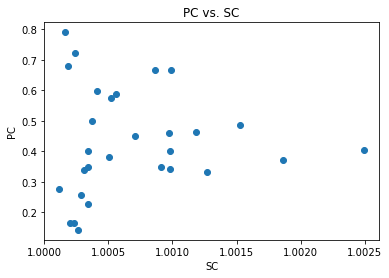

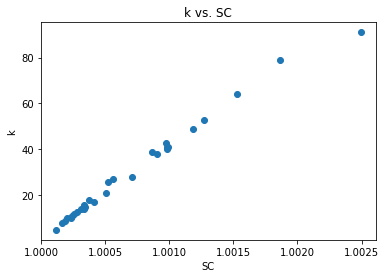

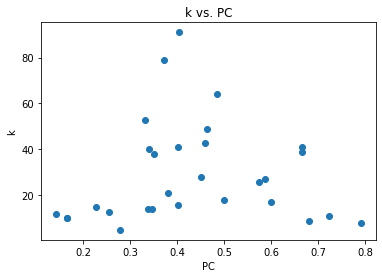

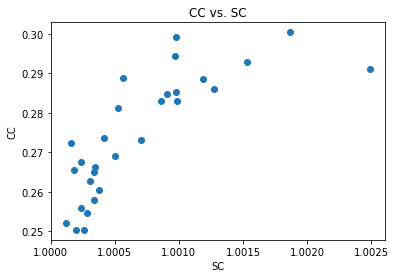

In [5]:
#generate scatter plots of centrality measures
import matplotlib.pyplot as plt
degrees=[91,79,64,53,49,43,41,41,40,39,38,28,27,26,21,18,17,16,15,14,14,13,12,11,10,10,9,8,5]
SC=[1.00249233362746,1.00186543452484,1.00152893516453,1.00127168363701,1.0011857168904,1.00097346760944,1.00098945839209,1.00098129752309,1.00097904251996,1.00086281688259,1.00090819748962,1.00070760723722,1.00056336569365,1.00052404590978,1.00050444107289,1.000375840656,1.00041421305962,1.00033883148953,1.00034218254982,1.00033792893474,1.00031041434706,1.00028412427241,1.0002609458976,1.00024008747918,1.0002337965078,1.00019967142068,1.00018507637882,1.00016237676213,1.00011817436057]
PC=[0.403119092627599,0.37125,0.484733727810651,0.331790672837309,0.464,0.459710743801653,0.665532879818594,0.401360544217687,0.340273646638905,0.66625,0.349769888231427,0.449464922711058,0.586734693877551,0.573388203017833,0.380165289256198,0.498614958448753,0.598765432098765,0.401384083044983,0.2265625,0.346666666666667,0.337777777777778,0.255102040816326,0.142011834319527,0.722222222222222,0.165289256198347,0.165289256198347,0.68,0.790123456790123,0.277777777777778]
#PC vs. SC
plt.title('PC vs. SC')
plt.xlabel('SC')
plt.ylabel('PC')
plt.scatter(SC,PC)
plt.show()
#k vs. SC
plt.title('k vs. SC')
plt.xlabel('SC')
plt.ylabel('k')
plt.scatter(SC,degrees)
plt.show()
#k vs. PC
plt.title('k vs. PC')
plt.xlabel('PC')
plt.ylabel('k')
plt.scatter(PC,degrees)
plt.show()


In [40]:
generate_summary(g, "summary.csv")

In [41]:
generate_summary(g_mutated, "summary_mutated.csv")